This is a dataset annotator using SAM. For every image in the datset, it allows the user to mannually draw bounding boxes on images, generate masks, ans convert them into YOLO format for training purposes.

In [1]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import torch
import random
from matplotlib import pyplot as plt

In [2]:
def apply_masks(img, masks):
    img = img.copy()
    for mask in masks:
        img[mask] = 255
    return img

In [3]:
img = cv2.imread("/home/nirshal/Downloads/car and bike.jpeg")
r = {}
while(True):
    label = input("Enter the label for the mask (exit to move to net image): ")

    if label == 'exit':
        break

    if label not in r:
        r[label] = {"bounding_box": [], "masks": []}

    
    while True:
        bbox = cv2.selectROI("Interactive Menu", img)
    
        convert = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
        r[label]["bounding_box"].append(np.asarray(convert))
        cv2.destroyAllWindows()

        cont = input("Draw another bounding box for the same label? (y/n): ")
        if cont.lower() != 'y':
            break  # Move to the next label


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


In [4]:
print("\nSegmenting the objects, this might take a while")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
# sam.to(device)
mask_predictor = SamPredictor(sam)
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(img2)

for label in r:
    for bbox in r[label]["bounding_box"]:
        mask, _, _ = mask_predictor.predict(box=bbox, multimask_output=False)
        r[label]["masks"].append(mask)




Segmenting the objects, this might take a while


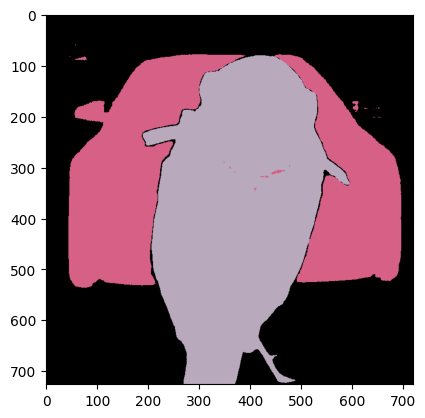

In [5]:
mask_visualization = np.zeros_like(img)

for label in r:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    for mask in r[label]["masks"]:
        mask_visualization[mask[0]] = color

plt.imshow(mask_visualization)
plt.show()
